In [7]:
import scipy.integrate
import scipy.optimize
import sys
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

In [8]:
class SIR:
    def __init__(self, S, I, R, beta, gamma):
        self.S = S
        self.I = I
        self.R = R
        self.beta = beta
        self.gamma = gamma
        self.t = 0.
        self.N = S + I + R
        self.times = None

    def reset(self, S, I, R, t=0.):
        self.t = t
        self.S = S
        self.I = I
        self.R = R


class SIR_stochastic(SIR):

    def __init__(self, S, I, R, beta, gamma):
        super().__init__(S, I, R, beta, gamma)
        self.Slist = []
        self.Ilist = []
        self.Rlist = []
        self.Nlist = []
        self.tlist = []

    def event(self):
        # Implement of Gillespie's Direct Algorithm
        self.event_list()
        inf_rate = (self.beta * self.S * self.I) / self.N
        rec_rate = self.gamma * self.I
        total_rate = inf_rate + rec_rate
        # Gillespie’s Direct Algorithm
        event_p = pl.rand() * total_rate
        dt = -np.log(pl.rand()) / total_rate
        self.t += dt
        # transmission
        if 0 < event_p <= inf_rate:
            self.S -= 1
            self.I += 1
        # recovery
        elif inf_rate < event_p <= total_rate:
            self.I -= 1
            self.R += 1
        else:
            print('end')

    # record list
    def event_list(self):
        self.Slist.append(self.S)
        self.Ilist.append(self.I)
        self.Rlist.append(self.R)
        self.tlist.append(self.t)
        self.N = self.S + self.I + self.R
        self.Nlist.append(self.N)

    def run(self,T):
        while self.t <= T:
            if self.I == 0:
                break
            else:
                self.event()

class SIR_stochastic_demography(SIR_stochastic):
    def __init__(self, S, I, R, beta, gamma,mu):
        SIR_stochastic.__init__(self, S, I, R, beta, gamma)
        self.mu=mu

    def event(self):
        # Implement of Gillespie's Direct Algorithm
        self.event_list()
        self.N = self.S + self.I + self.R
        bir_rate = self.mu * self.N
        inf_rate = (self.beta * self.S * self.I) / self.N
        rec_rate = self.gamma * self.I
        Sdeath_rate = self.mu * self.S
        Ideath_rate = self.mu * self.I
        Rdeath_rate = self.mu * self.R
        # with demography
        total_rate = inf_rate + rec_rate + bir_rate + Sdeath_rate + Ideath_rate + Rdeath_rate
        # Gillespie’s Direct Algorithm
        event_p = pl.rand() * total_rate
        dt = -np.log(pl.rand()) / total_rate
        self.t += dt
        # transmission
        if 0 < event_p <= inf_rate:
            self.S -= 1
            self.I += 1
        # recovery
        elif inf_rate < event_p <= inf_rate + rec_rate:
            self.I -= 1
            self.R += 1
        # new born
        elif inf_rate + rec_rate < event_p <= inf_rate + rec_rate + bir_rate:
            self.S += 1
        # susceptible death
        elif inf_rate + rec_rate + bir_rate < event_p <= inf_rate + rec_rate + bir_rate + Sdeath_rate:
            self.S -= 1
        # infectious death
        elif inf_rate + rec_rate + bir_rate + Sdeath_rate < event_p <= inf_rate + rec_rate + bir_rate + Sdeath_rate + Ideath_rate:
            self.I -= 1
        # recovered death
        elif inf_rate + rec_rate + bir_rate + Sdeath_rate + Ideath_rate < event_p <= total_rate:
            self.R -= 1
        else:
            print('end')

class SIR_deterministic(SIR):
    def __init__(self,S, I, R, beta, gamma,mu,noise):
        SIR.__init__(self,S, I, R, beta, gamma)
        self.mu=mu
        self.noise=noise

    def dydt(self, initial, t):
        S, I, R = initial
        dSdt = self.mu*self.N-self.beta * S * I/self.N-self.noise-self.mu*S
        dIdt = self.beta * S * I/self.N+ self.noise - self.gamma * I-self.mu*I
        dRdt = self.gamma * I-self.mu*R
        return [dSdt, dIdt, dRdt]

    def run(self,T,dt):
        self.t=[0]
        y0 = np.array([self.S, self.I, self.R], dtype=float)
        self.times=np.arange(0,T,dt)
        self.result = scipy.integrate.odeint(self.dydt, y0, self.times)

class SIR_stochastic_demo_import(SIR_stochastic_demography):
    def event(self):
        # Implement of Gillespie's Direct Algorithm
        self.event_list()
        self.N = self.S + self.I + self.R
        bir_rate = self.mu * self.N
        inf_rate = (self.beta * self.S * self.I) / self.N
        rec_rate = self.gamma * self.I
        Sdeath_rate = self.mu * self.S
        Ideath_rate = self.mu * self.I
        Rdeath_rate = self.mu * self.R
        import_rate=0.02*np.sqrt(self.N) # import via external infection

        # with demography
        total_rate = inf_rate + rec_rate + bir_rate + Sdeath_rate + Ideath_rate + Rdeath_rate+import_rate
        # Gillespie’s Direct Algorithm
        event_p = pl.rand() * total_rate
        dt = -np.log(pl.rand()) / total_rate
        self.t += dt
        # transmission
        if 0 < event_p <= inf_rate:
            self.S -= 1
            self.I += 1
        # recovery
        elif inf_rate < event_p <= inf_rate + rec_rate:
            self.I -= 1
            self.R += 1
        # new born
        elif inf_rate + rec_rate < event_p <= inf_rate + rec_rate + bir_rate:
            self.S += 1
        # susceptible death
        elif inf_rate + rec_rate + bir_rate < event_p <= inf_rate + rec_rate + bir_rate + Sdeath_rate:
            self.S -= 1
        # infectious death
        elif inf_rate + rec_rate + bir_rate + Sdeath_rate < event_p <= inf_rate + rec_rate + bir_rate + Sdeath_rate + Ideath_rate:
            self.I -= 1
        # recovered death
        elif inf_rate + rec_rate + bir_rate + Sdeath_rate + Ideath_rate < event_p \
                <= inf_rate + rec_rate + bir_rate + Sdeath_rate + Ideath_rate+Rdeath_rate:
            self.R -= 1
        # import via external
        elif inf_rate + rec_rate + bir_rate + Sdeath_rate + Ideath_rate+Rdeath_rate< event_p\
                <=inf_rate + rec_rate + bir_rate + Sdeath_rate + Ideath_rate+Rdeath_rate+import_rate:
            self.S -= 1
            self.I += 1
        else:
            print('end')

    def run(self,T):
        count_extinction=0
        extinction_time=[]
        marker=0
        while self.t <= T:
            if self.I <= 0 and marker==0:
                count_extinction+=1
                extinction_time.append(self.t)
                marker=1
            elif self.I >0 and marker==1:
                marker=0
            self.event()
        # print('Number of extinction:', count_extinction)
        # print('Time of first extinction', extinction_time[0])
        return [count_extinction,extinction_time]


class SIR_metapopulation:
    def __init__(self, Xi, Yi, Zi, Xj, Yj, Zj, beta, gamma, rho_ij, rho_ji):
        self.Xi = Xi
        self.Yi = Yi
        self.Zi = Zi
        self.Ni = self.Xi + self.Yi + self.Zi
        self.Xj = Xj
        self.Yj = Yj
        self.Zj = Zj
        self.Nj = self.Xj + self.Yj + self.Zj
        self.beta = beta
        self.gamma = gamma
        self.rho_ij = rho_ij
        self.rho_ji = rho_ji
        self.t = 0.
        self.times = None
        self.Xi_list = []
        self.Yi_list = []
        self.Zi_list = []
        self.Xj_list = []
        self.Yj_list = []
        self.Zj_list = []
        self.tlist = []

    def event(self):
        # Implement of Gillespie's Direct Algorithm
        self.event_list()
        inf_rate_i = (self.beta * self.Xi * self.Yi) / self.Ni
        inf_rate_j = (self.beta * self.Xj * self.Yj) / self.Nj
        rec_rate_i = self.gamma * self.Yi
        rec_rate_j = self.gamma * self.Yj
        # coupling from j to i and from i to j
        rho_rate_ij = self.beta * self.rho_ij * self.Yj / self.Ni
        rho_rate_ji = self.beta * self.rho_ji * self.Yi / self.Nj
        total_rate = inf_rate_i + inf_rate_j + rec_rate_i + rec_rate_j + rho_rate_ij + rho_rate_ji
        # Gillespie’s Direct Algorithm
        event_p = pl.rand() * total_rate
        dt = -np.log(pl.rand()) / total_rate
        self.t += dt
        # I-subpopulation inside transmission
        if 0 < event_p <= inf_rate_i:
            self.Xi -= 1
            self.Yi += 1
        # J-subpopulation inside transmission
        elif inf_rate_i < event_p <= inf_rate_i + inf_rate_j:
            self.Xj -= 1
            self.Yj += 1
        # I-subpopulation inside recovery
        elif inf_rate_i + inf_rate_j < event_p <= inf_rate_i + inf_rate_j + rec_rate_i:
            self.Yi -= 1
            self.Zi += 1
        # J-subpopulation inside recovery
        elif inf_rate_i + inf_rate_j + rec_rate_i < event_p <= inf_rate_i + inf_rate_j + rec_rate_i + rec_rate_j:
            self.Yj -= 1
            self.Zj += 1
        # coupling from j to i
        elif inf_rate_i + inf_rate_j + rec_rate_i + rec_rate_j < event_p <= inf_rate_i + inf_rate_j + rec_rate_i + rec_rate_j + rho_rate_ij:
            self.Xi -= 1
            self.Yi += 1
        # coupling from i to j
        elif inf_rate_i + inf_rate_j + rec_rate_i + rec_rate_j + rho_rate_ij < event_p <= total_rate:
            self.Xj -= 1
            self.Yj += 1
        else:
            print('end')

    # record list
    def event_list(self):
        self.Xi_list.append(self.Xi)
        self.Yi_list.append(self.Yi)
        self.Zi_list.append(self.Zi)
        self.Xj_list.append(self.Xj)
        self.Yj_list.append(self.Yj)
        self.Zj_list.append(self.Zj)
        self.tlist.append(self.t)

    def run(self, T):
        while self.t <= T:
            if self.Yi == 0 and self.Yj == 0:
                break
            else:
                self.event()
                
class SIR_metapopulation3:
    def __init__(self,Xi,Yi,Zi,Xj,Yj,Zj,Xk,Yk,Zk,beta,gamma,rho_ij,rho_jk,rho_ki):
        self.Xi=Xi
        self.Yi=Yi
        self.Zi=Zi
        self.Ni=self.Xi+self.Yi+self.Zi
        self.Xj=Xj
        self.Yj=Yj
        self.Zj=Zj
        self.Nj=self.Xj+self.Yj+self.Zj
        self.Xk=Xk
        self.Yk=Yk
        self.Zk=Zk
        self.Nk=self.Xk+self.Yk+self.Zk
        self.beta=beta
        self.gamma=gamma
        self.rho_ij=rho_ij
        self.rho_jk=rho_jk
        self.rho_ki=rho_ki
        self.t=0.
        self.times = None
        self.Xi_list=[]
        self.Yi_list=[]
        self.Zi_list=[]
        self.Xj_list=[]
        self.Yj_list=[]
        self.Zj_list=[]
        self.Xk_list=[]
        self.Yk_list=[]
        self.Zk_list=[]
        self.tlist=[]
    
    def event(self):
        #Implement of Gillespie's Direct Algorithm
        self.event_list()
        inf_rate_i=(self.beta*self.Xi*self.Yi)/self.Ni
        inf_rate_j=(self.beta*self.Xj*self.Yj)/self.Nj
        inf_rate_k=(self.beta*self.Xk*self.Yk)/self.Nk
        rec_rate_i=self.gamma*self.Yi
        rec_rate_j=self.gamma*self.Yj
        rec_rate_k=self.gamma*self.Yk
        #coupling from j to i,from k to j,from i to k
        rho_rate_ij=self.beta*self.rho_ij*self.Yj/self.Ni
        rho_rate_jk=self.beta*self.rho_jk*self.Yk/self.Nj
        rho_rate_ki=self.beta*self.rho_ki*self.Yi/self.Nk
        total_rate=inf_rate_i+inf_rate_j+inf_rate_k+rec_rate_i+rec_rate_j+rec_rate_k+rho_rate_ij+rho_rate_jk+rho_rate_ki
        #Gillespie’s Direct Algorithm
        event_p=pl.rand()*total_rate
        dt = -np.log(pl.rand())/total_rate 
        self.t +=dt
        #I-subpopulation inside transmission
        if 0<event_p<=inf_rate_i:
            self.Xi-=1
            self.Yi+=1
        #J-subpopulation inside transmission
        elif inf_rate_i<event_p<=inf_rate_i+inf_rate_j:
            self.Xj-=1
            self.Yj+=1
        #K-subpopulation inside transmission
        elif inf_rate_i+inf_rate_j<event_p<=inf_rate_i+inf_rate_j+inf_rate_k:
            self.Xk-=1
            self.Yk+=1
        #I-subpopulation inside recovery
        elif inf_rate_i+inf_rate_j+inf_rate_k<event_p<=inf_rate_i+inf_rate_j+inf_rate_k+rec_rate_i:
            self.Yi-=1
            self.Zi+=1
        #J-subpopulation inside recovery
        elif inf_rate_i+inf_rate_j+inf_rate_k+rec_rate_i<event_p<=inf_rate_i+inf_rate_j+inf_rate_k+rec_rate_i+rec_rate_j:
            self.Yj-=1
            self.Zj+=1
        #K-subpopulation inside recovery
        elif inf_rate_i+inf_rate_j+inf_rate_k+rec_rate_i+rec_rate_j<event_p<=inf_rate_i+inf_rate_j+inf_rate_k+rec_rate_i+rec_rate_j+rec_rate_k:
            self.Yk-=1
            self.Zk+=1
        #coupling from j to i
        elif inf_rate_i+inf_rate_j+inf_rate_k+rec_rate_i+rec_rate_j+rec_rate_k<event_p<=inf_rate_i+inf_rate_j+inf_rate_k+rec_rate_i+rec_rate_j+rec_rate_k+rho_rate_ij:
            self.Xi-=1
            self.Yi+=1
        #coupling from k to j
        elif inf_rate_i+inf_rate_j+inf_rate_k+rec_rate_i+rec_rate_j+rec_rate_k+rho_rate_ij<event_p<=inf_rate_i+inf_rate_j+inf_rate_k+rec_rate_i+rec_rate_j+rec_rate_k+rho_rate_ij+rho_rate_jk:
            self.Xj-=1
            self.Yj+=1
        #coupling from i to k
        elif inf_rate_i+inf_rate_j+inf_rate_k+rec_rate_i+rec_rate_j+rec_rate_k+rho_rate_ij+rho_rate_jk<event_p<=inf_rate_i+inf_rate_j+inf_rate_k+rec_rate_i+rec_rate_j+rec_rate_k+rho_rate_ij+rho_rate_jk+rho_rate_ki:
            self.Xk-=1
            self.Yk+=1
        else:
            print('end')
            
    #record list
    def event_list(self):
        self.Xi_list.append(self.Xi)
        self.Yi_list.append(self.Yi)
        self.Zi_list.append(self.Zi)
        self.Xj_list.append(self.Xj)
        self.Yj_list.append(self.Yj)
        self.Zj_list.append(self.Zj)
        self.Xk_list.append(self.Xk)
        self.Yk_list.append(self.Yk)
        self.Zk_list.append(self.Zk)
        self.tlist.append(self.t)
   
    def run(self,T):
        while self.t <= T:
            if self.Yi == 0 and self.Yj == 0 and self.Yk == 0:
                break
            else:
                self.event()

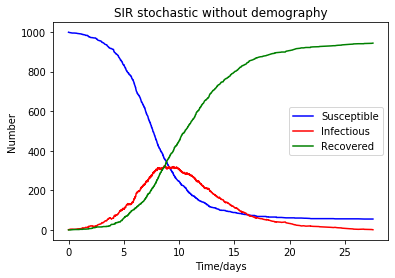

In [9]:
'''''
Problem1 SIR stochastic without demography
'''''
solution=SIR_stochastic(999,1,0,1,1/3)
solution.run(200)
plt.plot(solution.tlist, np.array(solution.Slist), c="b", label="Susceptible")
plt.plot(solution.tlist, np.array(solution.Ilist), c="r", label="Infectious")
plt.plot(solution.tlist, np.array(solution.Rlist), c="g", label="Recovered")
plt.legend()
plt.xlabel("Time/days")
plt.ylabel("Number")
plt.title("SIR stochastic without demography")
plt.savefig('SIR sto',dpi=500)
plt.show()

/Users/yuhao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()
/Users/yuhao/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


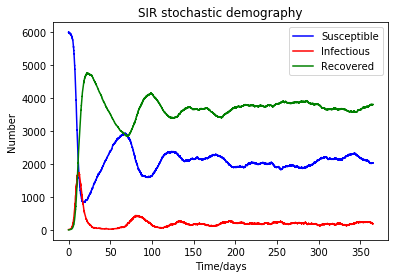

In [10]:
'''SIR stochastic with demography'''
solution=SIR_stochastic_demography(6000,10,0,1,1/3,1/60)
solution.run(365)
plt.plot(solution.tlist, np.array(solution.Slist), c="b", label="Susceptible")
plt.plot(solution.tlist, np.array(solution.Ilist), c="r", label="Infectious")
plt.plot(solution.tlist, np.array(solution.Rlist), c="g", label="Recovered")
plt.legend()
plt.xlabel("Time/days")
plt.ylabel("Number")
plt.title("SIR stochastic demography")
plt.savefig('SIR sto demography',dpi=500)
plt.show()

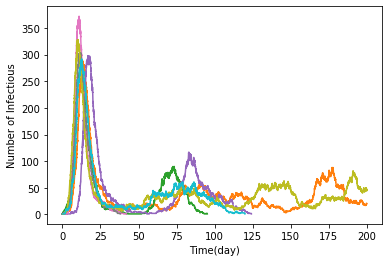

In [11]:
'''problem1 variability'''
for i in range(10):
    solution = SIR_stochastic_demography(999, 1, 0, 1, 1 / 3, 1 / 60)
    solution.run(200)
    #plt.plot(solution.tlist, np.array(solution.Slist), c="b", label="Susceptible")
    plt.plot(solution.tlist, np.array(solution.Ilist), label="Infectious")
    #plt.plot(solution.tlist, np.array(solution.Rlist), c="g", label="Recovered")
plt.xlabel('Time(day)')
plt.ylabel('Number of Infectious')
plt.savefig('variability',dpi=500)
plt.show()

COV matrix= [[6163.00797138 -279.67772841]
 [-279.67772841  519.82213941]]


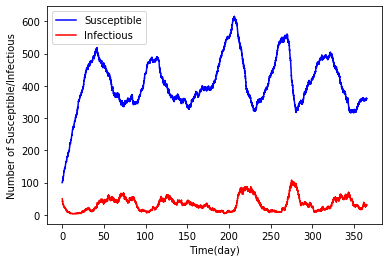

In [10]:
'''negative covarience'''
solution=SIR_stochastic_demography(100,50,1000,1,1/3,1/60)
solution.run(365)
S_sto=np.array(solution.Slist)
I_sto=np.array(solution.Ilist)
print('COV matrix=', np.cov(S_sto,I_sto))
plt.plot(solution.tlist, np.array(solution.Slist), c="b", label="Susceptible")
plt.plot(solution.tlist, np.array(solution.Ilist), c="r", label="Infectious")
plt.xlabel('Time(day)')
plt.ylabel('Number of Susceptible/Infectious')
plt.legend()
plt.savefig('Negative covar',dpi=1000)
plt.show()

In [6]:
'''negative covarience'''
cov_list=[]
for i in range(11):
    solution = SIR_stochastic_demography(100, 50, 1000, 1, 1 / 3, 1 / 60)
    solution.run(365)
    S_sto = np.array(solution.Slist)
    I_sto = np.array(solution.Ilist)
    cov_list.append(np.cov(S_sto,I_sto)[1,0])
    print('COV=', np.cov(S_sto,I_sto)[1,0])
print('Average covariance',np.average(cov_list))

COV= -732.5052411040907
COV= -993.7664842688465
COV= -848.2259662113872
COV= -700.892028115016
COV= -317.7126532025715
COV= -738.4135797376451
COV= -180.97139621174318
COV= -966.4079825097881
COV= -651.9125404403061
COV= -922.6238042507387
COV= -680.9521108662661
Average covariance -703.1257988107635


/Users/yuhao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


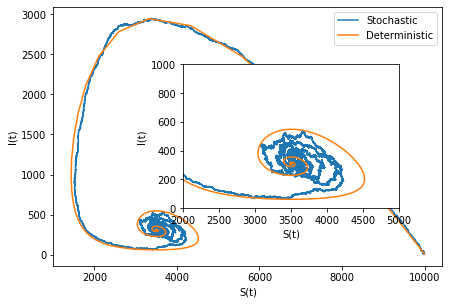

In [12]:
'''problem1 increased transient'''
solution=SIR_stochastic_demography(10000, 10, 0,1,1/3,1/60)
solution.run(365)
dSIR = SIR_deterministic(10000, 10, 0, 1, 1 / 3, 1 / 60, 0)
dSIR.run(365, 1)
S_sto=np.array(solution.Slist)
I_sto=np.array(solution.Ilist)
fig=plt.figure()
ax1=fig.add_axes([0.1, 0.1, 0.9, 0.9])
ax1.plot(S_sto,I_sto,label='Stochastic')
ax1.plot(dSIR.result[:,0],dSIR.result[:,1],label='Deterministic')
ax1.set_xlabel('S(t)')
ax1.set_ylabel('I(t)')
ax1.legend()

ax2=fig.add_axes([0.4, 0.3, 0.5, 0.5])
plt.plot(S_sto,I_sto,label='Stochastic')
plt.plot(dSIR.result[:,0],dSIR.result[:,1],label='Deterministic')
plt.xlim(2000,5000)
plt.ylim(0,1000)
plt.xlabel('S(t)')
plt.ylabel('I(t)')
plt.savefig('increased transient phase plot',dpi=500)
plt.show()

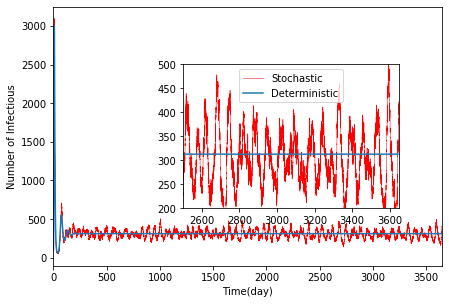

In [13]:
'''problem1 stochastic resonance'''
solution=SIR_stochastic_demography(10000,100,0,1,1/3,1/60)
solution.run(10*365)
dSIR = SIR_deterministic(10000, 100, 0, 1, 1/3, 1/60, 0)
dSIR.run(10*365, 1)
fig=plt.figure()
ax1=fig.add_axes([0.1, 0.1, 0.9, 0.9])
ax1.plot(solution.tlist, np.array(solution.Ilist), c="r", label="Stochastic",linewidth=0.5)
ax1.plot(dSIR.times,dSIR.result[:,1],label='Deterministic')
ax1.set_xlim(0,3650)
ax1.set_xlabel('Time(day)')
ax1.set_ylabel('Number of Infectious')

ax2=fig.add_axes([0.4, 0.3, 0.5, 0.5])
ax2.plot(solution.tlist, np.array(solution.Ilist), c="r", label="Stochastic",linewidth=0.5)
ax2.plot(dSIR.times,dSIR.result[:,1],label='Deterministic')
ax2.set_xlim(2500,3650)
ax2.set_ylim(200,500)
ax2.legend(loc='best')
plt.savefig('stochastic resonance2',dpi=500)
plt.show()

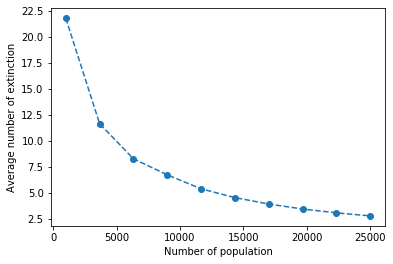

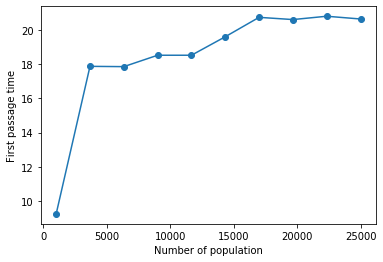

In [16]:
'''Problem1  extinction first & passage time'''
number_extiction_average=[]
number_population=np.array(np.linspace(1000,25000,10,endpoint=True))
number_extiction_average_N=[]
first_extinction_time_list=[]
first_passage_time_list_N=[]

for i in number_population:
    for j in range(10):
        solution = SIR_stochastic_demo_import(0.05*i,0.05*i, 0.9*i, 1, 2 / 3, 1 / 60)
        run_solution = solution.run(365)
        number_extiction_average.append(run_solution[0])
        extinction_time=run_solution[1]
        if run_solution[0]>0:
            first_extinction_time_list.append(extinction_time[0])
        else:
            #print('No extinction this time')
            pass
        j+=1
    #print('Average number of extinction:', np.average(number_extiction_average))
    #print('First Passage Time:',np.average(first_extinction_time_list))
    number_extiction_average_N.append(np.average(number_extiction_average))
    first_passage_time_list_N.append(np.average(first_extinction_time_list))
#print('number_population',number_population)
#print('number_extiction_average',number_extiction_average_N)
plt.plot(number_population,number_extiction_average_N,'o--')
plt.xlabel('Number of population')
plt.ylabel('Average number of extinction')
plt.savefig('number of extinction2',dpi=500)
plt.show()
plt.plot(number_population,first_passage_time_list_N,'o-')
plt.xlabel('Number of population')
plt.ylabel('First passage time')
plt.savefig('first passage time2',dpi=500)
plt.show()

Lag time is 43.38592349112095


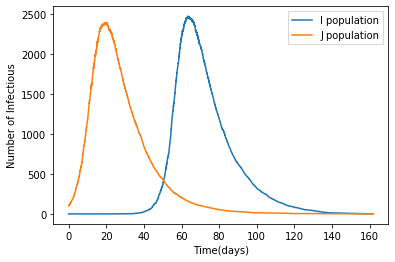

In [17]:
'''''Problem2 '''''

Stoc_meta_ij=SIR_metapopulation(5000,0,0,4900,100,0,0.3571,1/14,0.8,0)
Stoc_meta_ij.run(365)
peak_i=Stoc_meta_ij.Yi_list.index(max(Stoc_meta_ij.Yi_list))
peak_j=Stoc_meta_ij.Yj_list.index(max(Stoc_meta_ij.Yj_list))
plt.plot(Stoc_meta_ij.tlist, np.array(Stoc_meta_ij.Yi_list), label="I population")
plt.plot(Stoc_meta_ij.tlist, np.array(Stoc_meta_ij.Yj_list), label="J population")
plt.legend()
plt.xlabel("Time(days)")
plt.ylabel("Number of Infectious")

print('Lag time is',Stoc_meta_ij.tlist[peak_i]-Stoc_meta_ij.tlist[peak_j])
plt.savefig('2sub population',dpi=500)
plt.show()

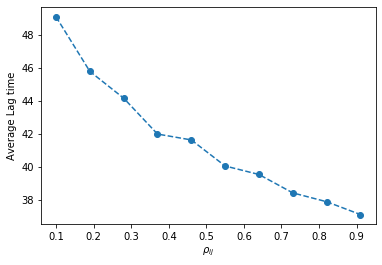

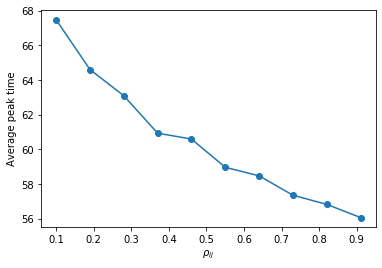

In [23]:
'''problem2 average lag time 2 subpopulation '''
rho_step=np.linspace(0.1,1,10,endpoint=False)
lag_time_range_list=[]
lag_time_list=[]
peak_time=[]
average_peak_time=[]
average_peak_time_list=[]
for rho in rho_step:
    count_nopeak = 0
    for i in range(20):
        Stoc_meta_ij = \
            SIR_metapopulation(5000, 0, 0, 4900, 100, 0, 0.3571, 1 / 14, rho, 0)
        Stoc_meta_ij.run(365)
        peak_i = Stoc_meta_ij.Yi_list.index(max(Stoc_meta_ij.Yi_list))
        peak_j = Stoc_meta_ij.Yj_list.index(max(Stoc_meta_ij.Yj_list))
        if peak_i>=1:
            lag_time = Stoc_meta_ij.tlist[peak_i] - Stoc_meta_ij.tlist[peak_j]
            lag_time_range_list.append(lag_time)
            peak_time.append(Stoc_meta_ij.tlist[peak_i])
        else:
            #print('No peak in sub-population i')
            count_nopeak+=1
    #print('count_nopeak', count_nopeak)
    average_lag_time=np.average(lag_time_range_list)
    lag_time_list.append(average_lag_time)
    average_peak_time=np.average(peak_time)
    average_peak_time_list.append(average_peak_time)

plt.plot(rho_step,lag_time_list,'o--')
plt.xlabel('$\\rho_{ij}$')
plt.ylabel("Average Lag time")
plt.savefig('Average lag time',dpi=500)
plt.show()

plt.plot(rho_step,average_peak_time_list,'o-')
plt.xlabel('$\\rho_{ij}$')
plt.ylabel("Average peak time")
plt.savefig('Average peak time',dpi=500)
plt.show()

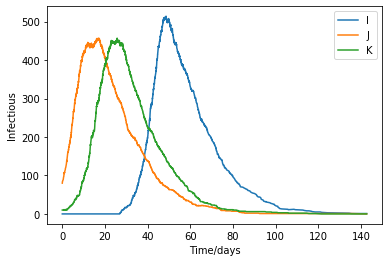

In [17]:
'''problem2 3 subpopulation'''
Stoc_meta_ijk=SIR_metapopulation3(1000,0,0,900,80,20,990,10,0,1/3,1/14,0.5,0.5,0.5)
Stoc_meta_ijk.run(365)
#peak_i=Stoc_meta_ij.Yi_list.index(max(Stoc_meta_ij.Yi_list))
#peak_j=Stoc_meta_ij.Yj_list.index(max(Stoc_meta_ij.Yj_list))
plt.plot(Stoc_meta_ijk.tlist, np.array(Stoc_meta_ijk.Yi_list), label="I")
plt.plot(Stoc_meta_ijk.tlist, np.array(Stoc_meta_ijk.Yj_list), label="J")
plt.plot(Stoc_meta_ijk.tlist, np.array(Stoc_meta_ijk.Yk_list), label="K")
plt.legend()
plt.xlabel("Time/days")
plt.ylabel("Infectious")
plt.savefig('3sub population',dpi=1000)
plt.show()

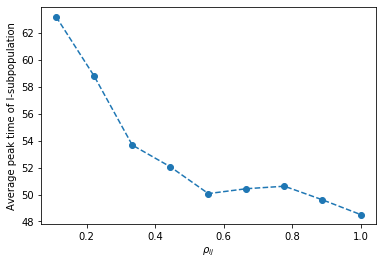

In [16]:
rho_step=np.linspace(0,1,10)
peak_i_timelist=[]
avg_peaki_timelist=[]
for rho_ij in rho_step:
    for i in range(10):
        stoc_meta_ijk = \
            Stoc_meta_ijk=SIR_metapopulation3(1000,0,0,900,80,20,990,10,0,1/3,1/14,rho_ij,0.5,0.5)
        Stoc_meta_ijk.run(365)
        peak_i=Stoc_meta_ijk.Yi_list.index(max(Stoc_meta_ijk.Yi_list))
        if peak_i>=1:
            peak_i_time=Stoc_meta_ijk.tlist[peak_i]
            peak_i_timelist.append(peak_i_time)
        else:
            pass
    avg_peaki_time=np.mean(peak_i_timelist)
    avg_peaki_timelist.append(avg_peaki_time)
plt.plot(rho_step, np.array(avg_peaki_timelist), 'o--')
plt.xlabel('$\\rho_{ij}$')
plt.ylabel("Average peak time of I-subpopulation")
plt.savefig('Average peak time 3sub',dpi=1000)
plt.show()